In [ ]:
!pip install pygeohash

In [15]:
from pyspark.sql import SparkSession, SQLContext, functions as F
from pyspark import StorageLevel
from pyspark.sql.window import Window
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkb
import pygeohash as pgh

In [ ]:
import datetime
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
from ggv.utils.context import create_default_context
context = create_default_context()

In [17]:
spark = SparkSession.builder\
    .appName('spark_session')\
    .config('spark.driver.memory', '8g')\
    .config("spark.driver.maxResultSize", "0")\
    .getOrCreate()

In [ ]:
conf = conf = spark._jsc.hadoopConfiguration() # datasource configuration

conf.set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") # S3 implementation class
conf.set("com.amazonaws.services.s3.enableV4", "true") # enable V4 signature that S3 requires
conf.set("fs.s3a.access.key", context.get_value('aws.default')['aws_access_key_id']) # load secrets
conf.set("fs.s3a.secret.key", context.get_value('aws.default')['aws_secret_access_key'])

In [19]:
def get_polygon_data():
    sqlContext = SQLContext(sparkContext=spark.sparkContext, sparkSession=spark) 
    hk_db = context.get_value('YOUR CONTEXT') 
    url = "jdbc:postgresql://" + hk_db['host'] + ":5432/" + hk_db['database'] # prepare jdbc string
    regions_info = sqlContext.read \
        .format("jdbc") \
        .option("driver", 'org.postgresql.Driver') \
        .option("url", url) \
        .option("user", hk_db['user'])\
        .option("password", hk_db['password'])\
        .option("sslmode", "require")\
        .option("sslfactory", "org.postgresql.ssl.NonValidatingFactory")\
        .option("ssl", True) \
        .option("query", """
            SELECT 
                region_id,
                name,
                eng_name,
                geohashes
            FROM TableName 
            WHERE 
                country = 'HK'
                AND level=2
        """).load()
    regions_info.persist(StorageLevel.MEMORY_AND_DISK)
    return regions_info

In [ ]:
start_date = datetime.datetime(year=2021, month=4, day=10)
end_date = datetime.datetime(year=2021, month=4, day=13)

def generate_folders_list(start_date, end_date, interval=datetime.timedelta(days=1), 
                          country='HK', bucket='YOUR_BUCKET_NAME'):
    folders_to_load = []
    curr_date = start_date
    
    while curr_date < end_date:
        prefix='Prefix' \
               f'/validated/{country.lower()}/partner_1.0.0/dt={curr_date.strftime("%Y-%m-%d")}/'
        
        s3_path = 's3a://' + bucket + '/' + prefix
        folders_to_load.append(s3_path)
        curr_date += interval
    return folders_to_load

country = 'HK'

folders_to_load = generate_folders_list(start_date, end_date, country=country)

In [ ]:
locations_df = spark.read.format('parquet').load(folders_to_load) # reads all folders in the list
locations_df = locations_df.persist(StorageLevel.DISK_ONLY) # can also choose DISK_ONLY or MEMORY_ONLY
regions_df = get_polygon_data()

In [ ]:
regions_df.printSchema()

In [69]:
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    try:
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
        # haversine formula 
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a)) 
        # Radius of earth in kilometers is 6371
        km = 6371* c
    except:
        km = 0.00
    return km
    
    
formated_df_rep = locations_df.repartition("partner_id")
formated_df_rep = formated_df_rep.persist(StorageLevel.MEMORY_ONLY)

get_distance_udf = F.udf(lambda a, b, c, d: haversine(a, b, c, d))
get_geohash_udf = F.udf(lambda x,y: pgh.encode(x, y, precision=8))

my_window = Window.partitionBy('partner_id').orderBy('datetime')

formated_df = formated_df_rep \
    .select('partner_id', 'datetime', 'location') \
    .withColumn("current_lat", F.col("location.lat")) \
    .withColumn("current_lon", F.col("location.lon")) \
    .withColumn("current_lat", F.col("location.lat")) \
    .withColumn("current_loc", get_geohash_udf('current_lat', 'current_lon')) \
    .withColumn("prev_lat", F.lag('current_lat').over(my_window)) \
    .withColumn("prev_lon", F.lag('current_lon').over(my_window)) \
    .withColumn("prev_time", F.lag('datetime').over(my_window)) \
    .withColumn("distance", get_distance_udf('current_lon','current_lat','prev_lon','prev_lat')) \
    .withColumn("time_stamp", F.unix_timestamp('datetime')) \
    .withColumn("prev_time_stamp", F.unix_timestamp('prev_time')) \
    .withColumn("time_diff", F.expr('time_stamp - prev_time_stamp')) \
    .withColumn("speed", F.expr('distance / time_diff'))

formated_df = formated_df.persist(StorageLevel.MEMORY_ONLY)

In [ ]:
formated_df.select('partner_id','current_lat','current_lon','current_loc').show(10)

In [ ]:
test_df = formated_df.limit(10).select('partner_id','current_lat','current_lon','current_loc')
test_df.show(10)

In [64]:
test_df \
.select('partner_id','current_lat','current_lon','current_loc') \
.join(regions_df, F.expr("array_contains(geohashes, current_loc)")) \
.show()

+----------+-----------+-----------+-----------+---------+----+--------+---------+
|partner_id|current_lat|current_lon|current_loc|region_id|name|eng_name|geohashes|
+----------+-----------+-----------+-----------+---------+----+--------+---------+
+----------+-----------+-----------+-----------+---------+----+--------+---------+



In [55]:
formated_df.groupBy('partner_id')\
    .agg(
        F.sum("time_diff").alias("total_time"),
        F.sum("distance").alias("total_distance"),
        F.mean("speed").alias("average_speed")
    )\
    .orderBy(F.desc('average_speed')) \
    .show(5)

+----------+----------+------------------+------------------+
|partner_id|total_time|    total_distance|     average_speed|
+----------+----------+------------------+------------------+
|     38967|    104554| 51.78707742071463| 2.364914072982106|
|     11033|    108077|13.862069916166053|1.4471288933223956|
|     32279|    186713| 17.82958262047659|1.2971705789127121|
|     27872|     95631| 45.03989894149417|0.8189652362594294|
|     41140|      3576| 4.728002383850653|0.6417323841420822|
+----------+----------+------------------+------------------+
only showing top 5 rows



In [93]:
shape_df = pd.read_csv('April_LLM_Scraper/hk_region_coords.csv')
shape_df['coords'] = shape_df['coordinates'].apply(lambda c: wkb.loads(c, hex=True))
shape_df

,zone_name,coordinates,coords
0,尖沙咀,0106000020E61000000100000001030000000100000028...,"(POLYGON ((114.161991 22.307185, 114.161929 22..."
1,佐敦,0106000020E6100000010000000103000000010000004B...,"(POLYGON ((114.15977 22.307902, 114.161038 22...."
2,紅磡,0106000020E61000000100000001030000000100000030...,"(POLYGON ((114.180935 22.298936, 114.182214 22..."
3,理工大學,0106000020E61000000100000001030000000100000029...,"(POLYGON ((114.182796 22.311858, 114.182241 22..."
4,土瓜灣,0106000020E6100000010000000103000000010000003F...,"(POLYGON ((114.18509 22.315463, 114.187482 22...."
5,油麻地,0106000020E61000000100000001030000000100000047...,"(POLYGON ((114.167905 22.309428, 114.168023 22..."
6,何文田,0106000020E61000000100000001030000000100000059...,"(POLYGON ((114.175697 22.312175, 114.174594 22..."
7,奧運,0106000020E61000000100000001030000000100000031...,"(POLYGON ((114.159788 22.309565, 114.16257 22...."
8,大角咀,0106000020E6100000010000000103000000010000002D...,"(POLYGON ((114.158029 22.321584, 114.158152 22..."
9,旺角,0106000020E61000000100000001030000000100000032...,"(POLYGON ((114.16515 22.323463, 114.165381 22...."


In [75]:
shape_df['lat_lon'] = shape_df['coordinates'].apply(lambda c: wkb.loads(c, hex=True))
shape_df['raw_coords'] = shape_df['lat_lon'].apply(lambda a: [np.dstack(b.coords.xy) for b in a.boundary])

In [80]:
target_coords = (22.3013002, 114.2377533)

shape_df['raw_coords'][0]

[array([[[ 114.161991,   22.307185],
         [ 114.161929,   22.307207],
         [ 114.161865,   22.307227],
         [ 114.161728,   22.307274],
         [ 114.16143 ,   22.307374],
         [ 114.16114 ,   22.30747 ],
         [ 114.160869,   22.307555],
         [ 114.159762,   22.3079  ],
         [ 114.15812 ,   22.305416],
         [ 114.153807,   22.305118],
         [ 114.153807,   22.29946 ],
         [ 114.154966,   22.298448],
         [ 114.15812 ,   22.298209],
         [ 114.159129,   22.29946 ],
         [ 114.16297 ,   22.300234],
         [ 114.164193,   22.294239],
         [ 114.16784 ,   22.292908],
         [ 114.173098,   22.29273 ],
         [ 114.175136,   22.292889],
         [ 114.180935,   22.298931],
         [ 114.180653,   22.299713],
         [ 114.180503,   22.300532],
         [ 114.180431,   22.300939],
         [ 114.18035 ,   22.301346],
         [ 114.180291,   22.302135],
         [ 114.179141,   22.302229],
         [ 114.178231,   22.302455],
 

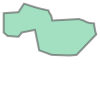

In [82]:
shape_df['lat_lon'][0]